# Looking for signals of attention
(and other mental states) in macaque V2

In [54]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import pandas as pd
from matplotlib.pyplot import *
from importlib import reload
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from copy import deepcopy

# NDNT network libs
import NDNT.utils as utils
import NDNT.NDNT as NDN
from NDNT.modules.layers import ChannelLayer, NDNLayer
from NDNT.networks import FFnetwork

import utils as ut
import lvutils as lv
import mattplotlib as m
import modellib as ml

def redo():
    reload(ut)
    reload(lv)
    reload(m)
    reload(ml)

In [2]:
# load the data
data = ut.load_data('ki_0503_V2b_py.mat')

../../data/hn/ ki_0503_V2b_py.mat
Loaded ki_0503_V2b_py.mat
118679 frames, 31 units, 848 trials with 116 frames each
  Time embedding...
  Time embedding...


In [146]:
time = np.zeros((data.NT))
time[:] = -1 # set all times to -1 so that empty rows are not treated incorrectly
for i in range(len(data.block_inds)):
    for j, t in enumerate(data.block_inds[i]):
        time[t] = j # count up from 0 to length of trial

trials = np.zeros((data.NT))
trials[:] = -1 # set all trials to -1 so that empty rows are not treated incorrectly
for i, trial in enumerate(data.block_inds): trials[trial] = i

cued = np.zeros((data.NT))
for i in range(0, len(data.block_inds)): cued[data.block_inds[i]] = data.TRcued[i]

choice = np.zeros((data.NT))
for i in range(0, len(data.block_inds)): choice[data.block_inds[i]] = data.TRchoice[i]

strength0 = np.zeros((data.NT))
for i in range(0, len(data.block_inds)): strength0[data.block_inds[i]] = data.TRstrength[i,0]
strength1 = np.zeros((data.NT))
for i in range(0, len(data.block_inds)): strength1[data.block_inds[i]] = data.TRstrength[i,1]

signal0 = np.zeros((data.NT))
for i in range(0, len(data.block_inds)): signal0[data.block_inds[i]] = data.TRsignal[i,0]
signal1 = np.zeros((data.NT))
for i in range(0, len(data.block_inds)): signal1[data.block_inds[i]] = data.TRsignal[i,1]


# put the data into a Pandas DataFrame for easier slicing and dicing
d = pd.DataFrame({
    "time": time,
    "trial": trials,
    #"stim": [pd.Series(data.stim[i].numpy()) for i in range(0, data.NT)], # this seems unnecessary for now
    "cued": cued,
    "choice": choice,
    "strength0": strength0,
    "strength1": strength1,
    "signal0": signal0,
    "signal1": signal1
})

# add the robs to the dataframe
for cell in range(data.robs.shape[1]):
    d['r'+str(cell)] = data.robs[:, cell]


In [157]:
d

,time,trial,cued,choice,strength0,strength1,signal0,signal1,r0,r1,...,r21,r22,r23,r24,r25,r26,r27,r28,r29,r30
0,0.0,0.0,1.0,-1.0,0.07,0.27,-1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,-1.0,0.07,0.27,-1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,1.0,-1.0,0.07,0.27,-1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,1.0,-1.0,0.07,0.27,-1.0,1.0,2.0,2.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
4,4.0,0.0,1.0,-1.0,0.07,0.27,-1.0,1.0,2.0,1.0,...,2.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118674,-1.0,-1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118675,-1.0,-1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118676,-1.0,-1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118677,-1.0,-1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Figure size 432x288 with 0 Axes>

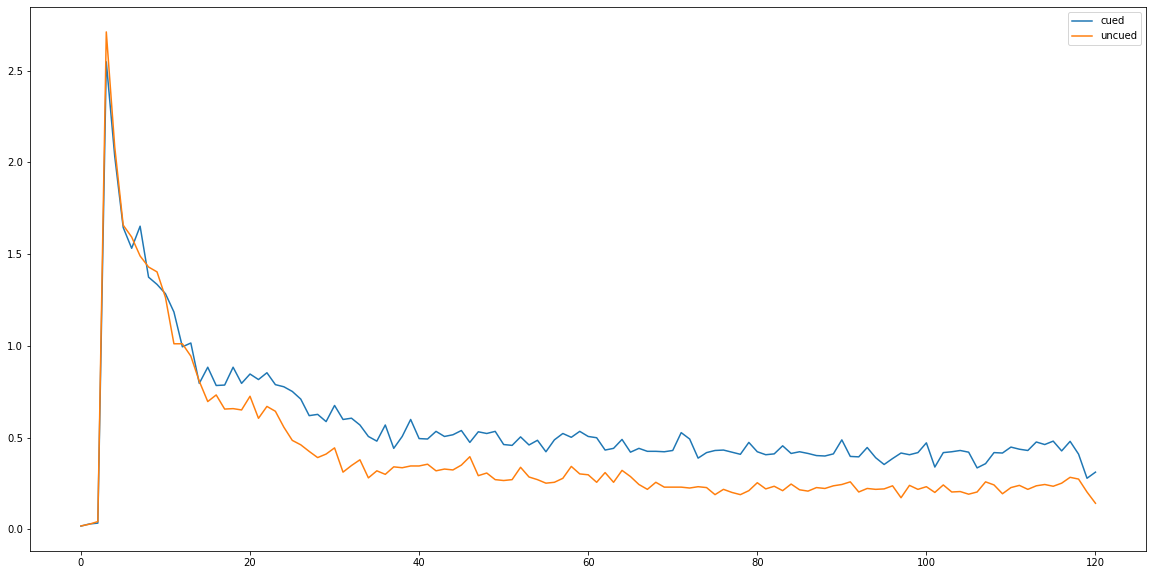

In [155]:
m.fig()
plt.plot(d[d.cued == 1].groupby(['time']).r1.mean(), label='cued')
plt.plot(d[d.cued == -1].groupby(['time']).r1.mean(), label='uncued')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

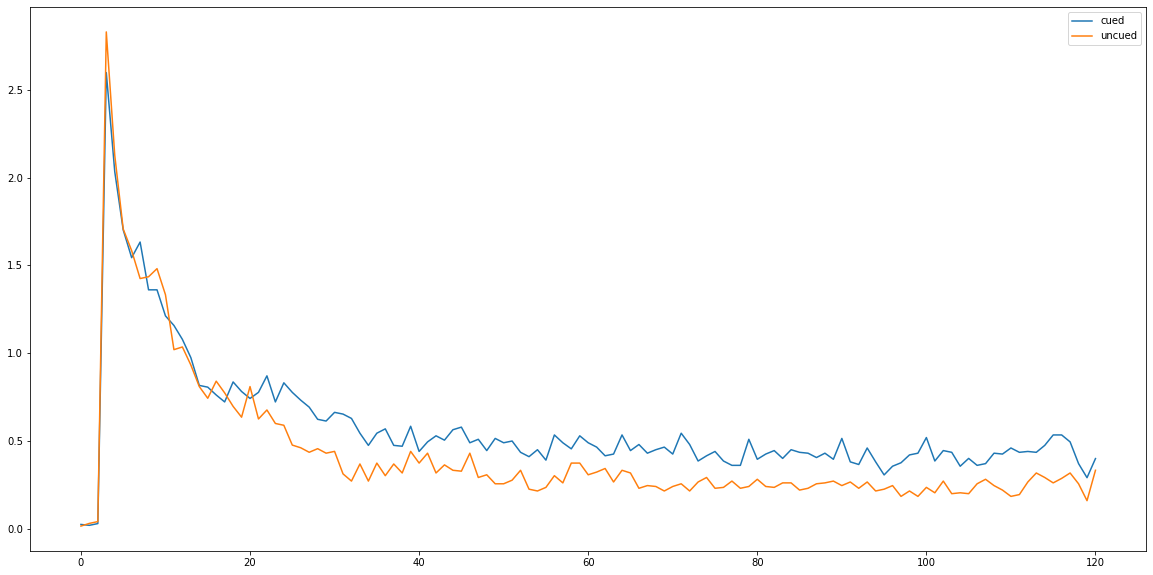

In [156]:
m.fig()
plt.plot(d[(d.cued == 1) & (d.signal1 == -1)].groupby(['time']).r1.mean(), label='cued')
plt.plot(d[(d.cued == -1) & (d.signal0 == -1)].groupby(['time']).r1.mean(), label='uncued')
plt.legend()
plt.show()

# Define the LBFGS params

In [3]:
lbfgs_pars = utils.create_optimizer_params(
    optimizer_type='lbfgs',
    tolerance_change=1e-10,
    tolerance_grad=1e-10,
    batch_size=2000,
    history_size=100,
    max_epochs=3,
    max_iter=2000)

# Train NULL (DRIFT) Model

Mean LL-Drift: 2.5082483


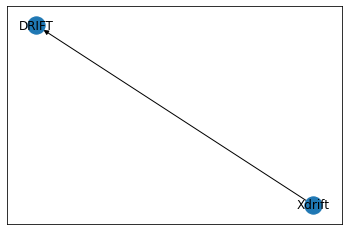

In [4]:
# define the DRIFT, train it before adding it to the network
drift_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, data.Xdrift.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='softplus')
drift_pars['reg_vals'] = {'d2t': 0.1, 'bcs': {'d2t': 0}}

drift_net = FFnetwork.ffnet_dict(xstim_n='Xdrift', layer_list=[drift_pars])

# Stand-alone drift model
drift_mod = NDN.NDN(ffnet_list=[drift_net], loss_type='poisson')


# Train the DRIFT Model
drift_mod.fit(data, force_dict_training=True, **lbfgs_pars, verbose=0)
# evaluate model using null-adjusted log-likelihood
LLsDrift = drift_mod.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LL-Drift:", np.mean(LLsDrift))

ml.draw_network(drift_mod, names=['DRIFT'])

<Figure size 432x288 with 0 Axes>

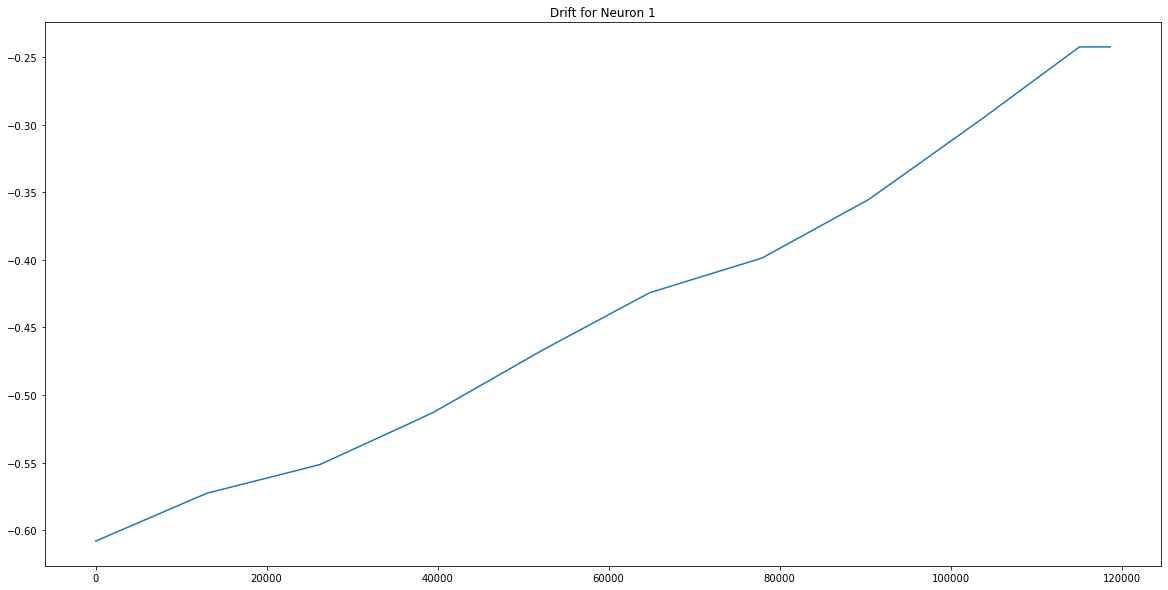

In [5]:
# Check that DRIFT model weights (e.g. predictions), try to make them smoother

# get the weights for the DRIFT network
driftw = drift_mod.networks[0].layers[0].weight.data
data.Xdrift.shape, driftw.shape
# predict the firing rates from the DRIFT
predRs = data.Xdrift @ driftw

m.fig()
plt.plot(predRs[:,0])
plt.title("Drift for Neuron 1")
plt.show()

# ADAPTATION

## create the Xadapt feature

<Figure size 432x288 with 0 Axes>

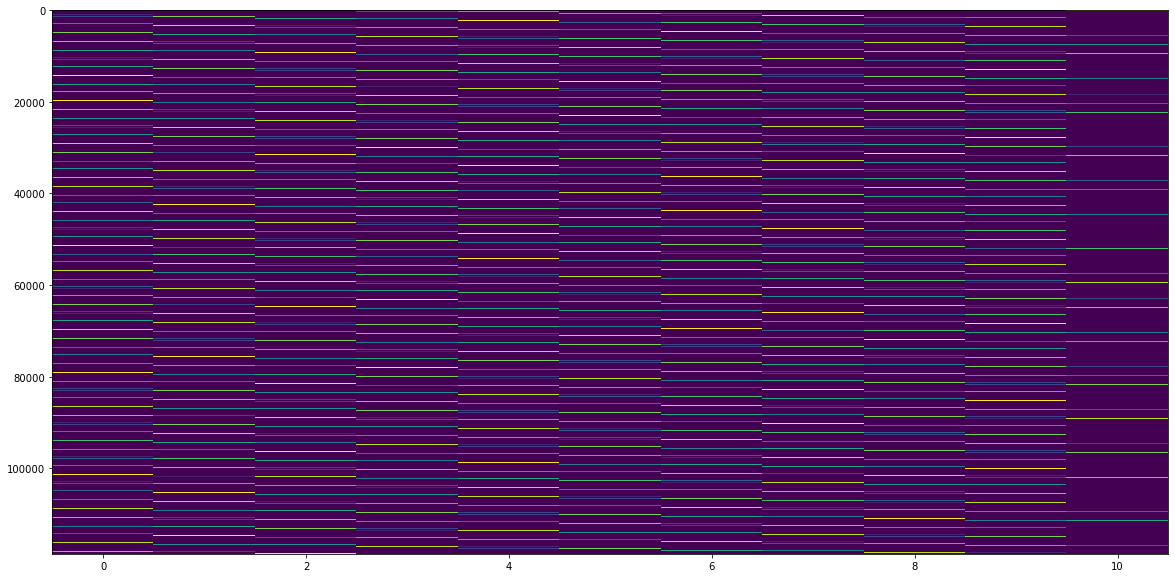

In [6]:
# populate the trials with tents
Xadapt = np.zeros((data.NT, 11))
for trial in data.block_inds:
    tents = data.design_matrix_drift(120, [i for i in range(10, 120, 10)])
    # copy this for each trial into the long list of tents
    Xadapt[trial[0]:trial[-1]] = tents[0:trial[-1]-trial[0]]

# add the feature to the dataset
data.add_covariate('Xadapt', Xadapt)

# plot the feature for testing
m.fig()
plt.imshow(Xadapt, aspect='auto', interpolation='none')
plt.show()

## train the model

Model: M031_N_N_N_A

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.3009631633758545 sec elapsed
Mean LL-Adapt: 0.07795321


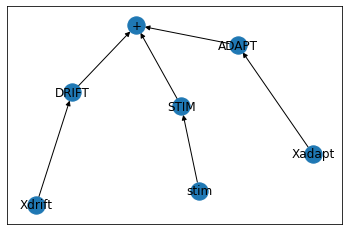

In [7]:
# define the DRIFT network
drift_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, data.Xdrift.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0, # Q: what norm type is this and why should we use it?
    NLtype='lin')
drift_pars['reg_vals'] = {'d2t': 0.2, 'bcs': {'d2t': 0}}
drift_net = FFnetwork.ffnet_dict(xstim_n='Xdrift', layer_list=[drift_pars])


# define the ADAPT network
adapt_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, Xadapt.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='lin')
adapt_pars['reg_vals'] = {'d2t': 0.1, 'bcs': {'d2t': 0}}
adapt_net = FFnetwork.ffnet_dict(xstim_n='Xadapt', layer_list=[adapt_pars])


# define the STIM network
stim_layer = NDNLayer.layer_dict(
    input_dims=data.stim_dims,
    num_filters=data.NC,
    bias=False,
    initialize_center=True,
    NLtype='lin')
stim_layer['reg_vals'] = {'d2xt': 0.2, 'bcs':{'d2xt': 1}}
stim_net = FFnetwork.ffnet_dict(xstim_n='stim', layer_list=[stim_layer])


# define the COMBINE network
comb_layer = ChannelLayer.layer_dict(
    num_filters=data.NC,
    NLtype='softplus',
    bias=True)
comb_layer['weights_initializer'] = 'ones'
comb_net = FFnetwork.ffnet_dict(xstim_n=None, ffnet_n=[0, 1, 2], layer_list=[comb_layer], ffnet_type='add')

# define the COMPLETE model
adapt_mod = NDN.NDN(ffnet_list=[drift_net, adapt_net, stim_net, comb_net], loss_type='poisson')

# copy the fit drift weights into this network and freeze them
adapt_mod.networks[0].layers[0].weight.data = deepcopy(driftw)
adapt_mod.set_parameters(val=False, name='weight', ffnet_target=0)

# Draw the network
ml.draw_network(adapt_mod, ['DRIFT', 'ADAPT', 'STIM','+'] )

# Train the complete adapt_mod
# it automatically uses the train_inds specified in the Dataset object when calling fit()
adapt_mod.fit(data, force_dict_training=True, **lbfgs_pars, verbose=1)
# evaluate the adapt_mod
LLsALL = adapt_mod.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LL-Adapt:", np.mean(LLsDrift - LLsALL))

## analyze results

<Figure size 432x288 with 0 Axes>

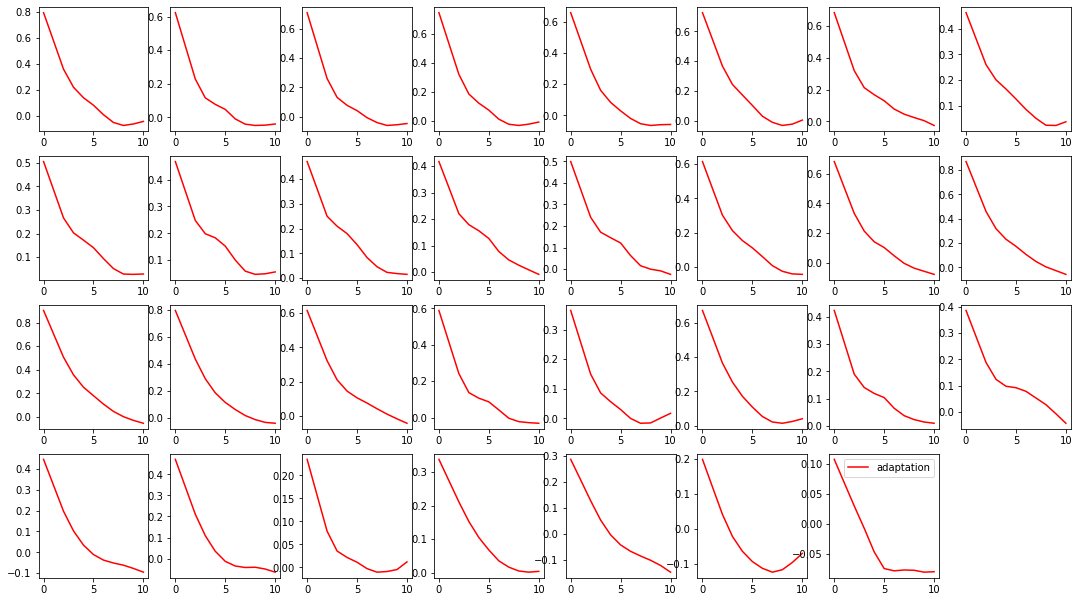

In [8]:
# compare XadaptU with XadaptC weights after fitting the model
fig = m.fig()
fig.set_size_inches(18.5, 10.5)
for c in range(data.NC):
    plt.subplot(4,8, c+1)
    plt.plot(adapt_mod.networks[1].layers[0].weight.data[range(0,11), c], 'r', label='adaptation')
plt.legend()
plt.show()

# I believe this is telling us how much adaptation there is when the monkey is
# paying attention vs. not paying attention.
# It kind of looks like, when they are cued, they respond a lot at the beginning
# and then stop.
# -- talked with Dan, and he agreed with this interpretation.

In [ ]:
'''
Looking at the evolution of firing activity over time (across trials), 
we do indeed see that the firing rate decreases, 
indicating neural adaptation.
''' 

## TODO: compare results with PSTH

In [53]:
# TODO: put creation of PSTH into utils or lvutils library.


## TODO: validate model output with PSTH

# CUEDvUNCUED+ADAPTION

## create the XadaptCU feature

<Figure size 432x288 with 0 Axes>

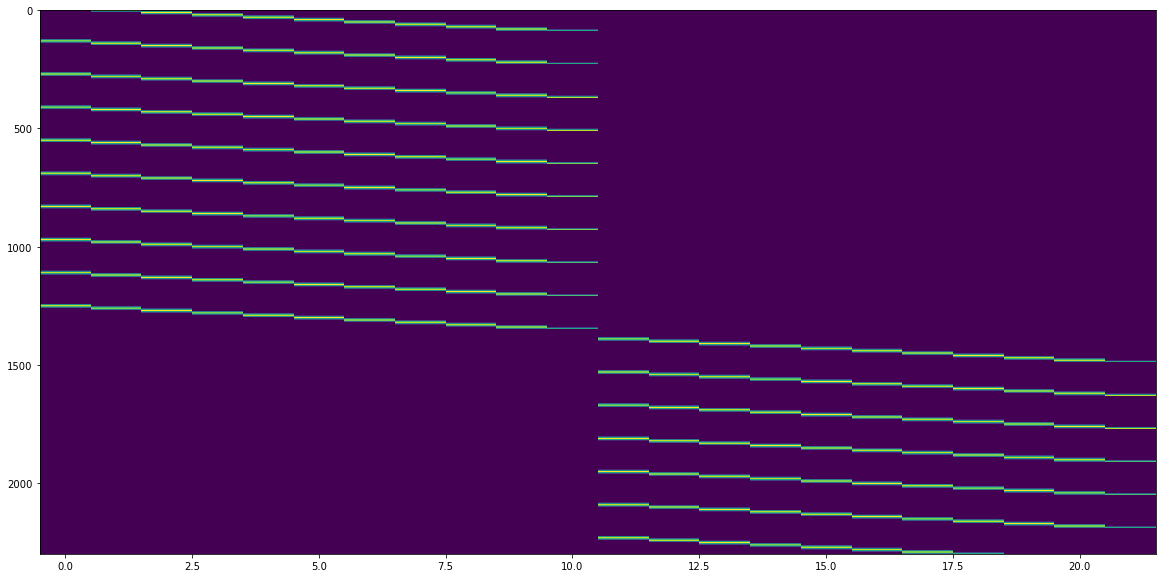

In [43]:
# split Xadapt by cued and uncued trials
trcued = np.where(data.TRcued > 0)[0]
truncued = np.where(data.TRcued < 0)[0]
cued = []
for tr in trcued: cued.extend(data.block_inds[tr])
uncued = []
for tr in truncued: uncued.extend(data.block_inds[tr])

# concatenate these as separate features into a new cued+uncued design matrix
XadaptC = deepcopy(Xadapt)
XadaptU = deepcopy(Xadapt)
XadaptC[uncued] = 0
XadaptU[cued] = 0
XadaptCU = np.array([np.hstack((XadaptC[t,:], XadaptU[t,:])) for t in range(Xadapt.shape[0])])

# add the feature to the dataset
data.add_covariate('XadaptCU', XadaptCU)

# plot the feature for testing
m.fig()
plt.imshow(XadaptCU[5200:7500], aspect='auto', interpolation='none')
plt.show()

In [9]:
'''
The tent functions seem to be encoding the correct information.
'''

## train the model

Model: M031_N_N_N_A

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.082907199859619 sec elapsed
Mean LL-Adapt: 0.104839906


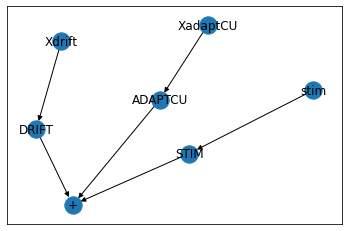

In [10]:
# define the DRIFT network
drift_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, data.Xdrift.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0, # Q: what norm type is this and why should we use it?
    NLtype='lin')
drift_pars['reg_vals'] = {'d2t': 0.2, 'bcs': {'d2t': 0}}
drift_net = FFnetwork.ffnet_dict(xstim_n='Xdrift', layer_list=[drift_pars])


# define the ADAPT network
adaptcu_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, XadaptCU.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='lin')
adaptcu_pars['reg_vals'] = {'d2t': 0.1, 'bcs': {'d2t': 0}}
adaptcu_net = FFnetwork.ffnet_dict(xstim_n='XadaptCU', layer_list=[adaptcu_pars])


# define the STIM network
stim_layer = NDNLayer.layer_dict(
    input_dims=data.stim_dims,
    num_filters=data.NC,
    bias=False,
    initialize_center=True,
    NLtype='lin')
stim_layer['reg_vals'] = {'d2xt': 0.2, 'bcs':{'d2xt': 1}}
stim_net = FFnetwork.ffnet_dict(xstim_n='stim', layer_list=[stim_layer])


# define the COMBINE network
comb_layer = ChannelLayer.layer_dict(
    num_filters=data.NC,
    NLtype='softplus',
    bias=True)
comb_layer['weights_initializer'] = 'ones'
comb_net = FFnetwork.ffnet_dict(xstim_n=None, ffnet_n=[0, 1, 2], layer_list=[comb_layer], ffnet_type='add')

# define the COMPLETE model
adaptcu_mod = NDN.NDN(ffnet_list=[drift_net, adaptcu_net, stim_net, comb_net], loss_type='poisson')

# copy the fit drift weights into this network and freeze them
adaptcu_mod.networks[0].layers[0].weight.data = deepcopy(driftw)
adaptcu_mod.set_parameters(val=False, name='weight', ffnet_target=0)

# Draw the network
ml.draw_network(adaptcu_mod, ['DRIFT', 'ADAPTCU', 'STIM','+'] )

# Train the complete adaptcu_mod
# it automatically uses the train_inds specified in the Dataset object when calling fit()
adaptcu_mod.fit(data, force_dict_training=True, **lbfgs_pars, verbose=1)
# evaluate the adaptcu_mod
LLsALL = adaptcu_mod.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LL-Adapt:", np.mean(LLsDrift - LLsALL))

## analyze results

<Figure size 432x288 with 0 Axes>

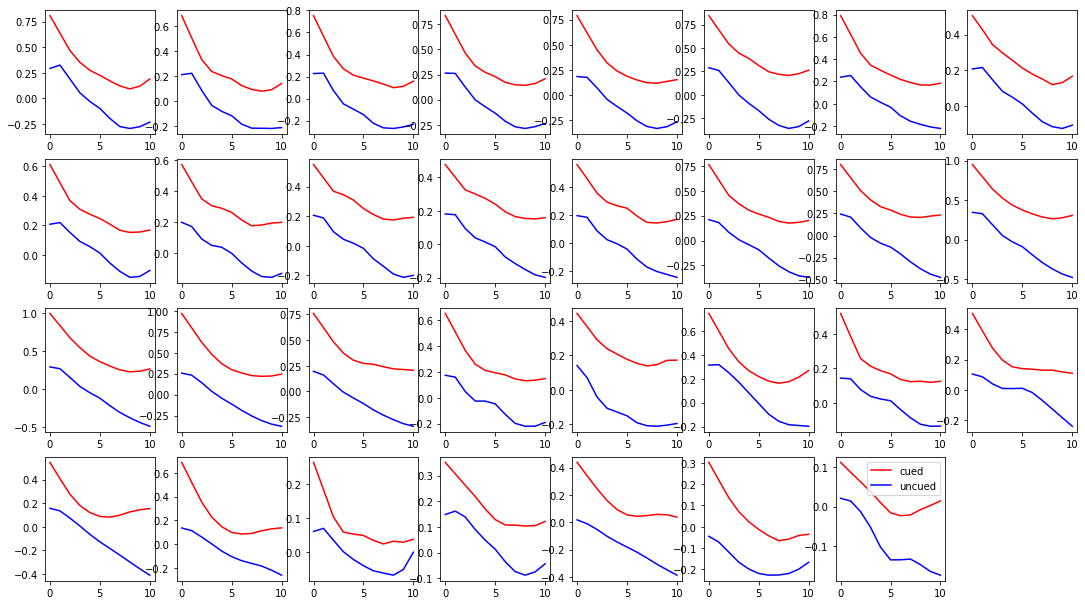

In [11]:
# compare XadaptU with XadaptC weights after fitting the model
fig = m.fig()
fig.set_size_inches(18.5, 10.5)
for c in range(data.NC):
    plt.subplot(4,8, c+1)
    plt.plot(adaptcu_mod.networks[1].layers[0].weight.data[range(0,11), c], 'r', label='cued')
    plt.plot(adaptcu_mod.networks[1].layers[0].weight.data[range(11,22), c], 'b', label='uncued')
plt.legend()
plt.show()


In [11]:
'''
In both cases, the neurons respond more at the beginning, but reduce over the course of the trial.
The uncued case shows less of a response overall, but with the same pattern.

INTERPRETATION:
The neurons respond more when the monkey is paying attention to the stimulus in their visual field,
than in the other visual field.
'''

# CUEDvUNCUED PSTH

## make the PSTH from the robs

<Figure size 432x288 with 0 Axes>

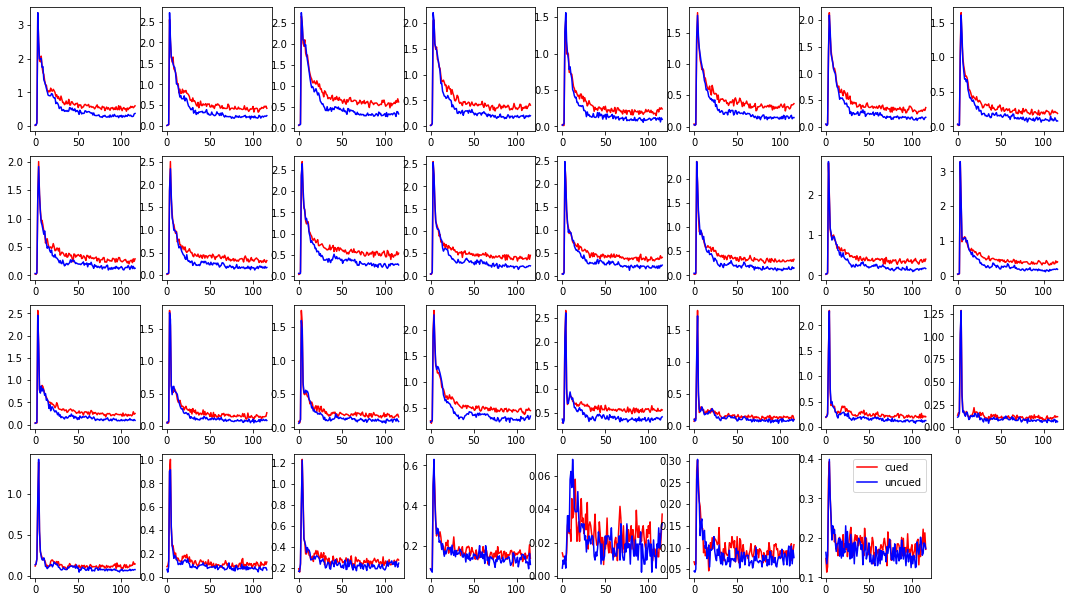

In [45]:
# average responses per neuron over trials, separated out for cued and uncued trials
# separate out robs into trials
min_trial_length = min([len(data.robs[trial]) for trial in data.block_inds])
trrobs = np.zeros((31, len(data.block_inds), min_trial_length))
for cell in range(data.NC):
    for trnum, trial in enumerate(data.block_inds):
        trrobs[cell, trnum, :] = data.robs[trial[0]:trial[0]+min_trial_length, cell]

# split by cued and uncued trials
trcued = np.where(data.TRcued > 0)[0]
truncued = np.where(data.TRcued < 0)[0]

trrobs_cued = trrobs[:, trcued, :]
trrobs_uncued = trrobs[:, truncued, :]

# average cells over trials
trrobs_cued_mean = np.mean(trrobs_cued, axis=1)
trrobs_uncued_mean = np.mean(trrobs_uncued, axis=1)

# plot the PSTH for each cell
fig = m.fig()
fig.set_size_inches(18.5, 10.5)
for c in range(data.NC):
    plt.subplot(4,8, c+1)
    plt.plot(trrobs_cued_mean[c, :], 'red', label='cued')
    plt.plot(trrobs_uncued_mean[c, :], 'blue', label='uncued')
plt.legend()
plt.show()


In [ ]:
'''
This does match the model results, which is good.
I should do PSTHs on the other data splits as well and compare them.
'''

## train a model to compare

Model: M031_N_N_A

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.0278968811035156 sec elapsed
Mean LL-Adapt: 0.042350736


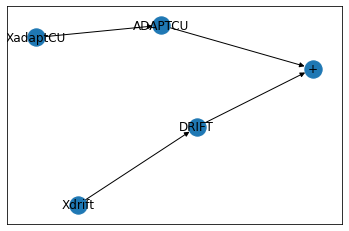

In [13]:
# define the DRIFT network
drift_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, data.Xdrift.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0, # Q: what norm type is this and why should we use it?
    NLtype='lin')
drift_pars['reg_vals'] = {'d2t': 0.2, 'bcs': {'d2t': 0}}
drift_net = FFnetwork.ffnet_dict(xstim_n='Xdrift', layer_list=[drift_pars])


# define the ADAPT network
adaptcu_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, XadaptCU.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='lin')
adaptcu_pars['reg_vals'] = {'d2t': 0.1, 'bcs': {'d2t': 0}}
adaptcu_net = FFnetwork.ffnet_dict(xstim_n='XadaptCU', layer_list=[adaptcu_pars])


# define the COMBINE network
comb_layer = ChannelLayer.layer_dict(
    num_filters=data.NC,
    NLtype='softplus',
    bias=True)
comb_layer['weights_initializer'] = 'ones'
comb_net = FFnetwork.ffnet_dict(xstim_n=None, ffnet_n=[0, 1], layer_list=[comb_layer], ffnet_type='add')

# define the COMPLETE model
model = NDN.NDN(ffnet_list=[drift_net, adaptcu_net, comb_net], loss_type='poisson')

# copy the fit drift weights into this network and freeze them
model.networks[0].layers[0].weight.data = deepcopy(driftw)
model.set_parameters(val=False, name='weight', ffnet_target=0)

# Draw the network
ml.draw_network(model, ['DRIFT', 'ADAPTCU', '+'] )

# Train the complete model
# it automatically uses the train_inds specified in the Dataset object when calling fit()
model.fit(data, force_dict_training=True, **lbfgs_pars, verbose=1)
# evaluate the model
LLsALL = model.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LL-Adapt:", np.mean(LLsDrift - LLsALL))

<Figure size 432x288 with 0 Axes>

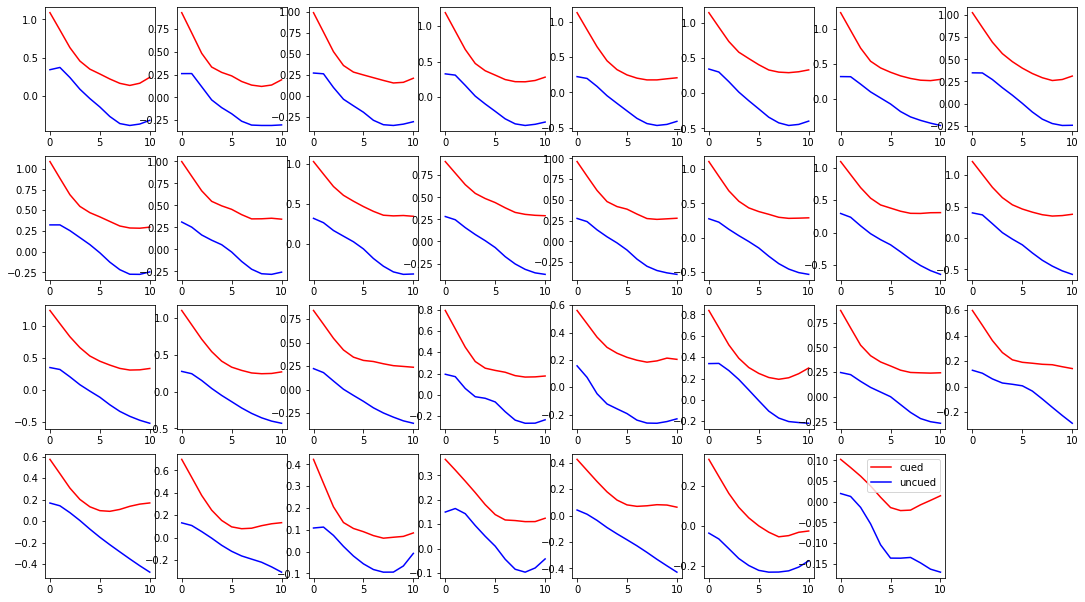

<Figure size 432x288 with 0 Axes>

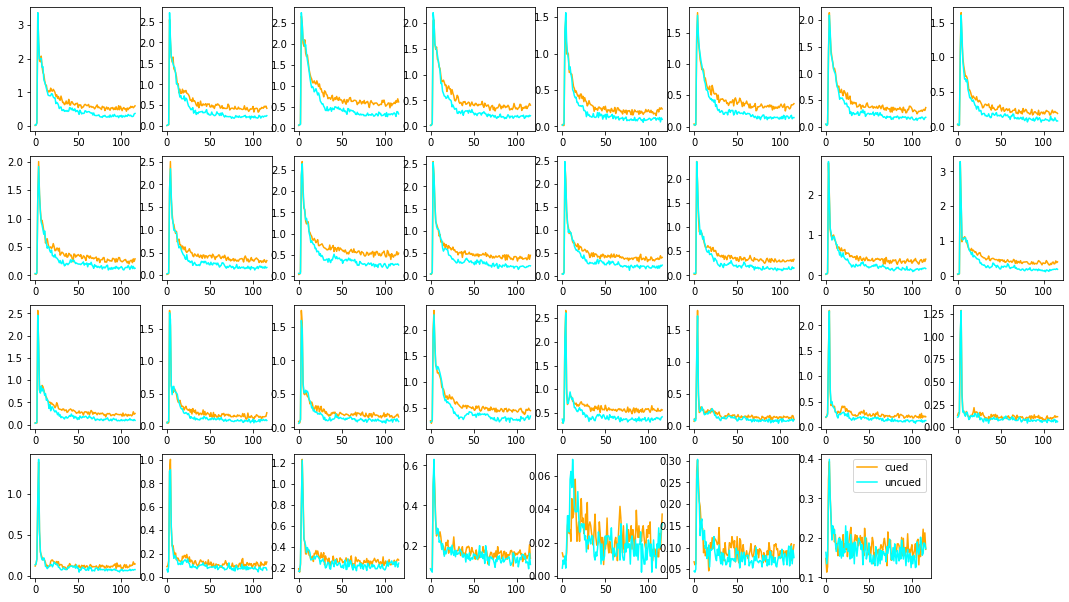

In [46]:
fig = m.fig()
fig.set_size_inches(18.5, 10.5)
for c in range(data.NC):
    plt.subplot(4,8, c+1)
    plt.plot(model.networks[1].layers[0].weight.data[range(0,11), c], 'red', label='cued')
    plt.plot(model.networks[1].layers[0].weight.data[range(11,22), c], 'blue', label='uncued')
plt.legend()
plt.show()

fig = m.fig()
fig.set_size_inches(18.5, 10.5)
for c in range(data.NC):
    plt.subplot(4, 8, c + 1)
    plt.plot(trrobs_cued_mean[c, :], 'orange', label='cued')
    plt.plot(trrobs_uncued_mean[c, :], 'cyan', label='uncued')
plt.legend()
plt.show()

## TODO: model output PSTH to compare

# CUEDvUNCUED+STRENGTH

## create XadaptStrCU features
(trial adaptation by strength)

<Figure size 432x288 with 0 Axes>

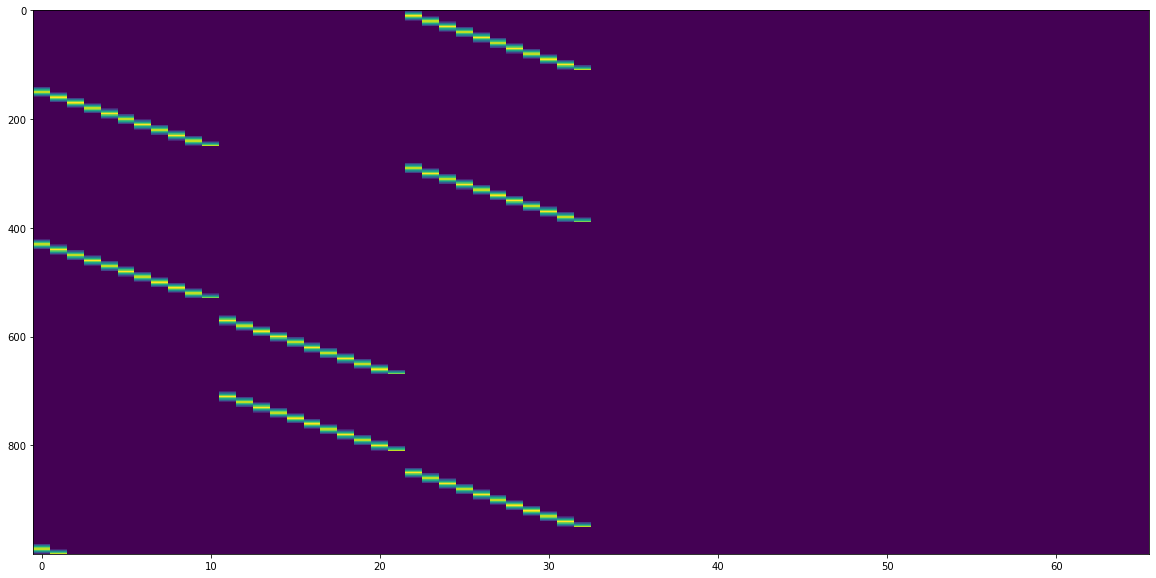

In [15]:
# create feature (and network) for trials where the signal is strong versus weak
XstrengthC = []
XstrengthU = []
XstrengthCU = []
# copy the strength from the side that is cued for cued trials 
#      and the side that is uncuded for uncued trials
# should I just copy it for every time point? let's try that and see how it works
trcued = deepcopy(data.TRcued)
trcued[np.where(trcued<0)] = 0
# get the strength based on the side that was cued

trstrength = np.zeros((len(trcued), 1))
for tr in range(len(trcued)):
    trstrength[tr] = data.TRstrength[tr, trcued[tr]]

# This feature breaks XadaptCU into trials where strength is 0, 0.07, or 0.27
trcuedstr0 = np.where((data.TRcued > 0) & (trstrength.T == 0.0))[1]
trcuedstr1 = np.where((data.TRcued > 0) & (trstrength.T == 0.07))[1]
trcuedstr2 = np.where((data.TRcued > 0) & (trstrength.T == 0.27))[1]
truncuedstr0 = np.where((data.TRcued < 0) & (trstrength.T == 0.0))[1]
truncuedstr1 = np.where((data.TRcued < 0) & (trstrength.T == 0.07))[1]
truncuedstr2 = np.where((data.TRcued < 0) & (trstrength.T == 0.27))[1]

cuedstr0 = []
for tr in trcuedstr0: cuedstr0.extend(data.block_inds[tr])
cuedstr1 = []
for tr in trcuedstr1: cuedstr1.extend(data.block_inds[tr])
cuedstr2 = []
for tr in trcuedstr2: cuedstr2.extend(data.block_inds[tr])
uncuedstr0 = []
for tr in trcuedstr0: cuedstr0.extend(data.block_inds[tr])
uncuedstr1 = []
for tr in trcuedstr1: cuedstr1.extend(data.block_inds[tr])
uncuedstr2 = []
for tr in trcuedstr2: cuedstr2.extend(data.block_inds[tr])


# concatenate these as separate features into a new cued+uncued design matrix
XadaptCS0 = np.zeros(Xadapt.shape)
XadaptCS1 = np.zeros(Xadapt.shape)
XadaptCS2 = np.zeros(Xadapt.shape)
XadaptUS0 = np.zeros(Xadapt.shape)
XadaptUS1 = np.zeros(Xadapt.shape)
XadaptUS2 = np.zeros(Xadapt.shape)

XadaptCS0[cuedstr0] = Xadapt[cuedstr0]
XadaptCS1[cuedstr1] = Xadapt[cuedstr1]
XadaptCS2[cuedstr2] = Xadapt[cuedstr2]
XadaptUS0[uncuedstr0] = Xadapt[uncuedstr0]
XadaptUS1[uncuedstr1] = Xadapt[uncuedstr1]
XadaptUS2[uncuedstr2] = Xadapt[uncuedstr2]

XadaptCUS = np.array([np.hstack((XadaptCS0[t,:],
                                 XadaptCS1[t,:],
                                 XadaptCS2[t,:],
                                 XadaptUS0[t,:],
                                 XadaptUS1[t,:],
                                 XadaptUS2[t,:])) for t in range(Xadapt.shape[0])])

data.add_covariate("XadaptCUS", XadaptCUS)

m.fig()
plt.imshow(XadaptCUS[:1000], aspect='auto', interpolation='none')
plt.show()

## train the model

Model: M031_N_N_N_A

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.7877893447875977 sec elapsed
Mean LL-Adapt: 0.09406358


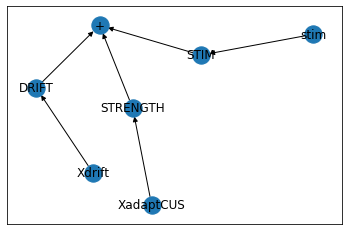

In [16]:
# define the DRIFT network
drift_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, data.Xdrift.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0, # Q: what norm type is this and why should we use it?
    NLtype='lin')
drift_pars['reg_vals'] = {'d2t': 0.2, 'bcs': {'d2t': 0}}
drift_net = FFnetwork.ffnet_dict(xstim_n='Xdrift', layer_list=[drift_pars])


# define the ADAPT network
adapt_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, XadaptCU.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='lin')
adapt_pars['reg_vals'] = {'d2t': 0.1, 'bcs': {'d2t': 0}}
adapt_net = FFnetwork.ffnet_dict(xstim_n='XadaptCU', layer_list=[adapt_pars])


# define the STRENGTH network
strength_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, XadaptCUS.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='lin')
strength_pars['reg_vals'] = {'d2t': 0.1, 'bcs': {'d2t': 0}}
strength_net = FFnetwork.ffnet_dict(xstim_n='XadaptCUS', layer_list=[strength_pars])


# define the STIM network
stim_layer = NDNLayer.layer_dict(
    input_dims=data.stim_dims,
    num_filters=data.NC,
    bias=False,
    initialize_center=True,
    NLtype='lin')
stim_layer['reg_vals'] = {'d2xt': 0.2, 'bcs':{'d2xt': 1}}
stim_net = FFnetwork.ffnet_dict(xstim_n='stim', layer_list=[stim_layer])


# define the COMBINE network
comb_layer = ChannelLayer.layer_dict(
    num_filters=data.NC,
    NLtype='softplus',
    bias=True)
comb_layer['weights_initializer'] = 'ones'
comb_net = FFnetwork.ffnet_dict(xstim_n=None, ffnet_n=[0, 1, 2], layer_list=[comb_layer], ffnet_type='add')

# define the COMPLETE model
strength_mod = NDN.NDN(ffnet_list=[drift_net, strength_net, stim_net, comb_net], loss_type='poisson')

# copy the fit drift weights into this network and freeze them
strength_mod.networks[0].layers[0].weight.data = deepcopy(driftw)
strength_mod.set_parameters(val=False, name='weight', ffnet_target=0)

# Draw the network
ml.draw_network(strength_mod, ['DRIFT', 'STRENGTH', 'STIM','+'] )

# Train the complete strength_mod
# it automatically uses the train_inds specified in the Dataset object when calling fit()
strength_mod.fit(data, force_dict_training=True, **lbfgs_pars, verbose=1)
# Evaluate the strength_mod
LLsALL = strength_mod.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LL-Adapt:", np.mean(LLsDrift - LLsALL))

## analyze results

<Figure size 432x288 with 0 Axes>

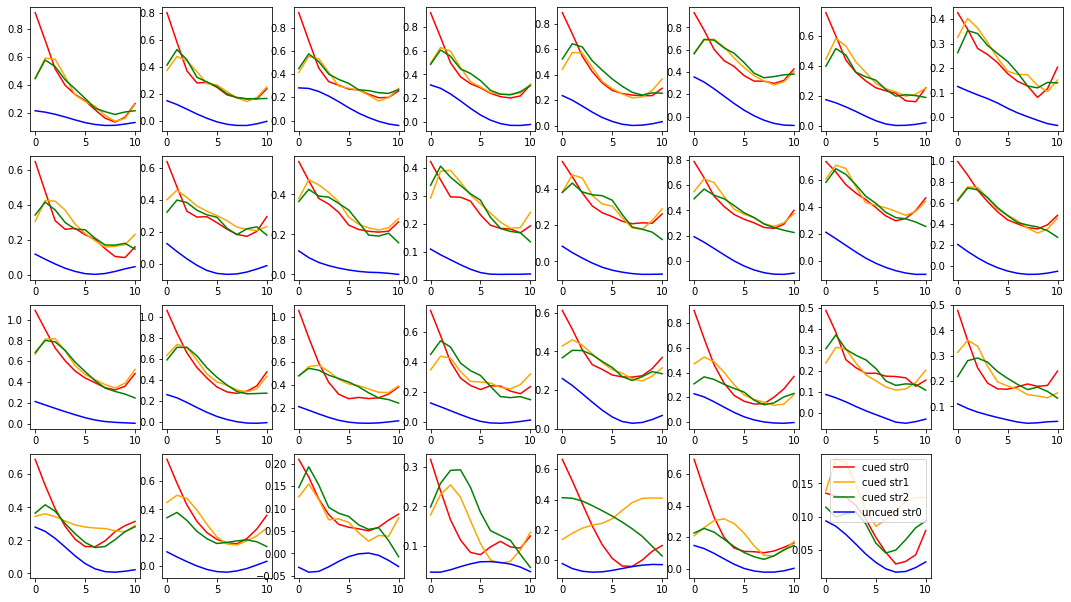

<Figure size 432x288 with 0 Axes>

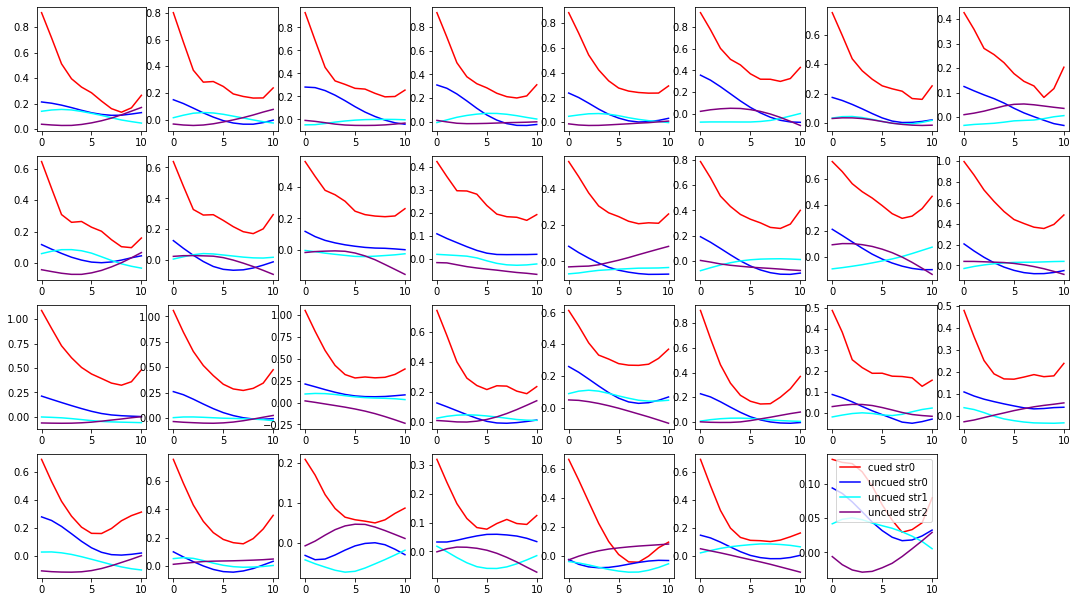

In [47]:
fig = m.fig()
fig.set_size_inches(18.5, 10.5)
for c in range(data.NC):
    plt.subplot(4,8, c+1)
    plt.plot(strength_mod.networks[1].layers[0].weight.data[range(0,11), c], 'red', label='cued str0')
    plt.plot(strength_mod.networks[1].layers[0].weight.data[range(11,22), c], 'orange', label='cued str1')
    plt.plot(strength_mod.networks[1].layers[0].weight.data[range(22,33), c], 'green', label='cued str2')
    plt.plot(strength_mod.networks[1].layers[0].weight.data[range(33,44), c], 'blue', label='uncued str0')
plt.legend()
plt.show()

fig = m.fig()
fig.set_size_inches(18.5, 10.5)
for c in range(data.NC):
    plt.subplot(4,8, c+1)
    plt.plot(strength_mod.networks[1].layers[0].weight.data[range(0,11), c], 'red', label='cued str0')
    plt.plot(strength_mod.networks[1].layers[0].weight.data[range(33,44), c], 'blue', label='uncued str0')
    plt.plot(strength_mod.networks[1].layers[0].weight.data[range(44,55), c], 'cyan', label='uncued str1')
    plt.plot(strength_mod.networks[1].layers[0].weight.data[range(55,66), c], 'purple', label='uncued str2')
plt.legend()
plt.show()

In [17]:
'''
Zero-strength trials, whether cued or uncued, start very strong and drop afterward.
However, the middle-strength and high-strength trials all start lower and follow the trends of cued or uncued after.
For cued, middle and high strength trials,
activity begins higher and decreases throughout the trial.
For uncued, middle strength trials,
activity begins lower, and will decrease or increase depending on the cell.
For uncued, high strength trials,
activity generally increases over the trial.

INTERPRETATION:
If you consider neural firing rates as indicating the cell coding for something (rate coding hypothesis),
then this could indicate that when the monkey is looking at the shape they are told to (CUED case),
that these neurons may be "attending" to it more at the beginning of the trial, paying less attention near the middle, 
and a little more right at the end, presumably to get "ready" for the next trial.
When they are looking at the other shape (UNCUED case),
then these neurons are not activated at all to pay attention to the shape.
Some are activated a little near the end of the trial, maybe because attention is shifting between sides?
'''

# CUEDvUNCUED+DISTANCE

## create XadaptDistCU features
(trial adaptation by distance)

<Figure size 432x288 with 0 Axes>

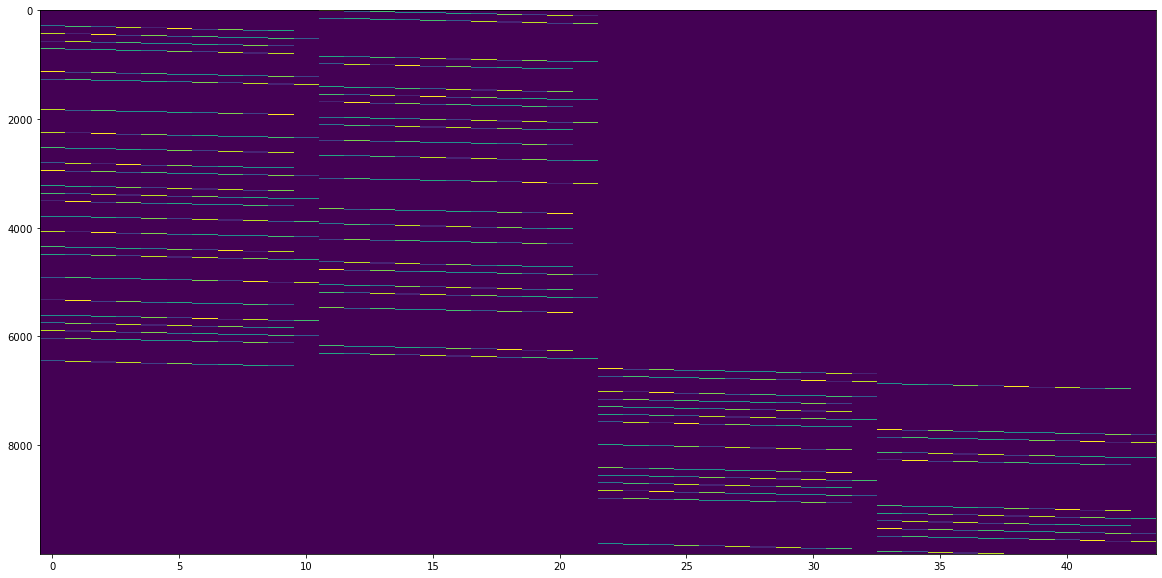

In [18]:
trcued = deepcopy(data.TRcued)
trcued[np.where(trcued<0)] = 0
# get the strength based on the side that was cued

signal = np.zeros((data.NT, 1))
trsignal = np.zeros((len(trcued), 1))
for tr in range(len(trcued)):
    trsignal[tr] = data.TRsignal[tr, trcued[tr]]
    signal[data.block_inds[tr]] = data.TRsignal[tr, trcued[tr]]

# This feature breaks XadaptCU into trials where signal for cued side is near or far
trcuednear = np.where((data.TRcued > 0) & (trsignal.T == -1))[1]
trcuedfar = np.where((data.TRcued > 0) & (trsignal.T == 1))[1]
truncuednear = np.where((data.TRcued < 0) & (trsignal.T == -1))[1]
truncuedfar = np.where((data.TRcued < 0) & (trsignal.T == 1))[1]


cuednear = []
for tr in trcuednear: cuednear.extend(data.block_inds[tr])
cuedfar = []
for tr in trcuedfar: cuedfar.extend(data.block_inds[tr])
uncuednear = []
for tr in truncuednear: uncuednear.extend(data.block_inds[tr])
uncuedfar = []
for tr in truncuedfar: uncuedfar.extend(data.block_inds[tr])


# concatenate these as separate features into a new cued+uncued design matrix
XadaptCN = np.zeros(Xadapt.shape)
XadaptCF = np.zeros(Xadapt.shape)
XadaptUN = np.zeros(Xadapt.shape)
XadaptUF = np.zeros(Xadapt.shape)

XadaptCN[cuednear] = Xadapt[cuednear]
XadaptCF[cuedfar] = Xadapt[cuedfar]
XadaptUN[uncuednear] = Xadapt[uncuednear]
XadaptUF[uncuedfar] = Xadapt[uncuedfar]

XadaptCUDIST = np.array([np.hstack((XadaptCN[t,:],
                                    XadaptCF[t,:],
                                    XadaptUN[t,:],
                                    XadaptUF[t,:])) for t in range(Xadapt.shape[0])])

# add the feature into the dataset
data.add_covariate("XadaptCUDIST", XadaptCUDIST)

# plot the feature for manual validation
m.fig()
plt.imshow(XadaptCUDIST[:10000], aspect='auto', interpolation='none')
plt.show()

## train the model

Model: M031_N_N_N_A

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.1665492057800293 sec elapsed
Mean LL-Adapt: 0.042350736


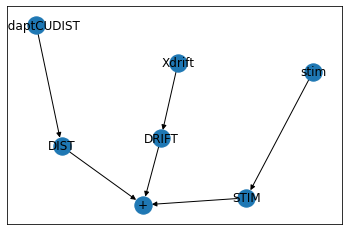

In [19]:
# define the DRIFT network
drift_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, data.Xdrift.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0, # Q: what norm type is this and why should we use it?
    NLtype='lin')
drift_pars['reg_vals'] = {'d2t': 0.2, 'bcs': {'d2t': 0}}
drift_net = FFnetwork.ffnet_dict(xstim_n='Xdrift', layer_list=[drift_pars])


# define the DIST network
distance_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, XadaptCUDIST.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='lin')
distance_pars['reg_vals'] = {'d2t': 0.1, 'bcs': {'d2t': 0}}
distance_net = FFnetwork.ffnet_dict(xstim_n='XadaptCUDIST', layer_list=[distance_pars])


# define the STIM network
stim_layer = NDNLayer.layer_dict(
    input_dims=data.stim_dims,
    num_filters=data.NC,
    bias=False,
    initialize_center=True,
    NLtype='lin')
stim_layer['reg_vals'] = {'d2xt': 0.2, 'bcs':{'d2xt': 1}}
stim_net = FFnetwork.ffnet_dict(xstim_n='stim', layer_list=[stim_layer])


# define the COMBINE network
comb_layer = ChannelLayer.layer_dict(
    num_filters=data.NC,
    NLtype='softplus',
    bias=True)
comb_layer['weights_initializer'] = 'ones'
comb_net = FFnetwork.ffnet_dict(xstim_n=None, ffnet_n=[0, 1, 2], layer_list=[comb_layer], ffnet_type='add')


# define the COMPLETE model
dist_mod = NDN.NDN(ffnet_list=[drift_net, distance_net, stim_net, comb_net], loss_type='poisson')


# copy the fit drift weights into this network and freeze them
dist_mod.networks[0].layers[0].weight.data = deepcopy(driftw)
dist_mod.set_parameters(val=False, name='weight', ffnet_target=0)


# Draw the network
ml.draw_network(dist_mod, ['DRIFT', 'DIST', 'STIM','+'] )


# Train the complete dist_mod
# it automatically uses the train_inds specified in the Dataset object when calling fit()
dist_mod.fit(data, force_dict_training=True, **lbfgs_pars, verbose=1)
# Evaluate the complete model
LLsALL = model.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LL-Adapt:", np.mean(LLsDrift - LLsALL))

## analyze results

<Figure size 432x288 with 0 Axes>

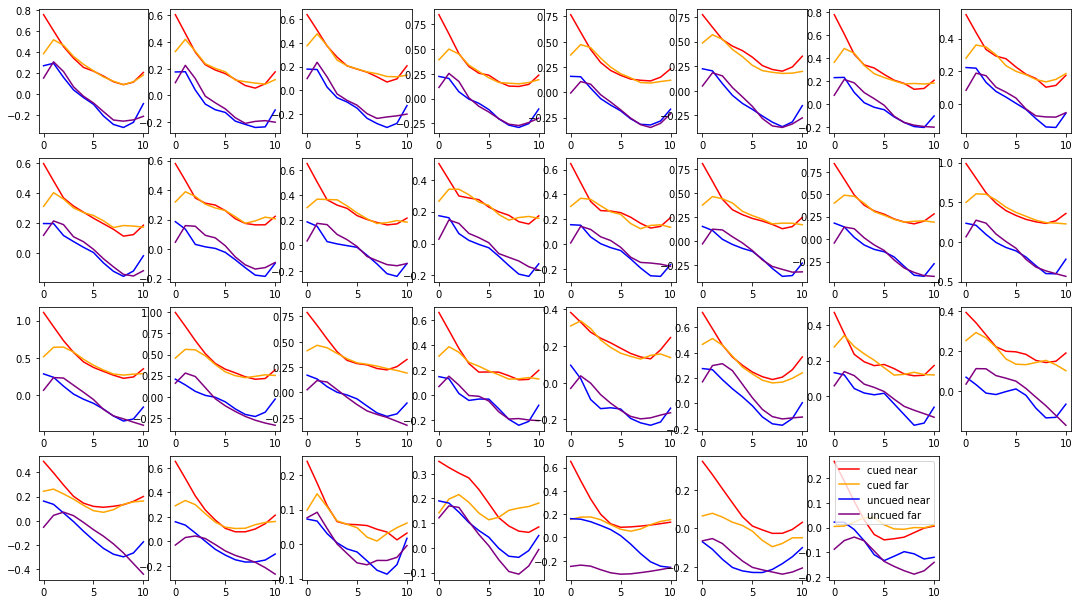

In [20]:
fig = m.fig()
fig.set_size_inches(18.5, 10.5)
for c in range(data.NC):
    plt.subplot(4,8, c+1)
    plt.plot(dist_mod.networks[1].layers[0].weight.data[range(0,11), c], 'red', label='cued near')
    plt.plot(dist_mod.networks[1].layers[0].weight.data[range(11,22), c], 'orange', label='cued far')
    plt.plot(dist_mod.networks[1].layers[0].weight.data[range(22,33), c], 'blue', label='uncued near')
    plt.plot(dist_mod.networks[1].layers[0].weight.data[range(33,44), c], 'purple', label='uncued far')
plt.legend()
plt.show()

In [20]:
'''
When the response is NEAR, the firing drops consistently whether the monkey was cued or not.
When the response is FAR, the firing increases a little, before dropping down in the same manner as in the near case.
In both cases, the firing increases near the end of the trial, possibly due to getting ready for the next trial.

INTERPRETATION:
Assuming rate coding, it could be that the neuron is delayed in detecting the object when it is father away,
possibly due to the monkey needing to focus?
'''

# CORRECTvINCORRECT

## psychophysics

In [21]:
stim_to_correct = {}
for sig, strength, side, choice in zip(data.TRsignal, data.TRstrength, data.TRcued, data.TRchoice):
    if side < 0: side = 0 # make -1 sides into 0 for indexing purposes
    side = 1 - side

    stim = sig[side]*strength[side] # stimulus is signal (-1 or +1) times it strength

    if stim not in stim_to_correct: stim_to_correct[stim] = [] # initialize if not created

    '''sig[side]*choice'''
    if choice > 0: # choice and signal have the same sign
        stim_to_correct[stim].append(1)
    else: # choice and signal have different signs
        stim_to_correct[stim].append(0)
        
    # TODO: plot cued vs. uncued


In [168]:
sides = data.TRcued.copy() # copy the array so we don't corrupt the raw data
sides[sides == 1] = 0 # make all +1 sides index into column 0
sides[sides == -1] = 1 # make all the -1 sides index into column 1
# create the array of stims which are the signal*strength at the given cued side
Xcued = [sig[side]*strength[side] for sig, side, strength in zip(data.TRsignal, sides, data.TRstrength)]
Xuncued = [sig[1-side]*strength[1-side] for sig, side, strength in zip(data.TRsignal, sides, data.TRstrength)]

# copy the array so we don't corrupt the raw data
Y = data.TRchoice.copy()
#  replace all -1 with 0 to make our choice counts easy to calculate by averaging
Y[Y == -1] = 0

stimscued = np.unique(Xcued) # get the unique stimulus values
# get the mean choices for each unique stimulus value
responsescued = [Y[np.where(Xcued == stim)].mean() for stim in stimscued]

stimsuncued = np.unique(Xuncued) # get the unique stimulus values
# get the mean choices for each unique stimulus value
responsesuncued = [Y[np.where(Xuncued == stim)].mean() for stim in stimsuncued]

<Figure size 432x288 with 0 Axes>

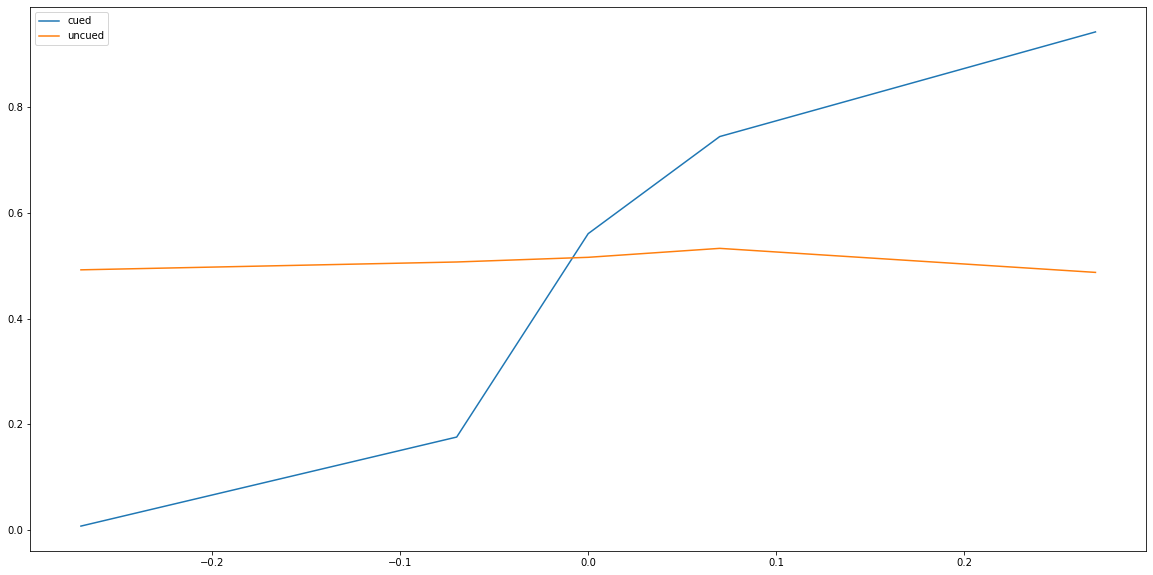

In [169]:
m.fig()
plt.plot(stimscued, responsescued, label='cued')
plt.plot(stimsuncued, responsesuncued, label='uncued')
plt.legend()
plt.show()

## create the correct feature

In [49]:
# trials where the monkey answered correctly and where the monkey did not
trcorinc = np.zeros((848))
i = 0
for sig, strength, side, choice in zip(data.TRsignal, data.TRstrength, data.TRcued, data.TRchoice):
    # make -1 sides into 0 for indexing purposes (side index = sidx)
    if side < 0: 
        side = 0
    else:
        side = 1
    side = 1 - side

    # only count the trial if there was signal, not zero strength signal
    if strength[side] > 0:
        # TODO: double check with Dan that this is the right way to determine correctness
        if choice == sig[side]: # choice and signal have the same sign
            trcorinc[i] = 1
        if choice != sig[side]: # choice and signal have the same sign
            trcorinc[i] = -1
    
    i += 1

len(trcorinc)

848

<Figure size 432x288 with 0 Axes>

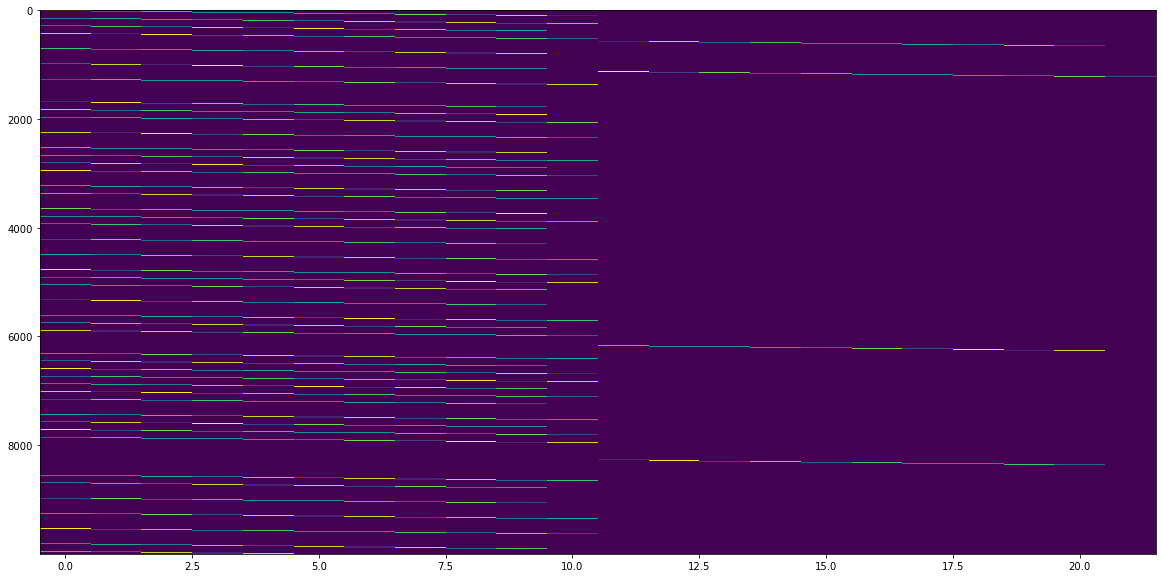

In [50]:
# skip when trcorinc is 0 (zero strength trials)
trcorrect = np.where(trcorinc == 1)[0]
trincorrect = np.where(trcorinc == -1)[0]

correct = []
for tr in trcorrect: correct.extend(data.block_inds[tr])
incorrect = []
for tr in trincorrect: incorrect.extend(data.block_inds[tr])

# concatenate these as separate features into a new correct+incorrect design matrix
XadaptCOR = np.zeros(Xadapt.shape)
XadaptINC = np.zeros(Xadapt.shape)

XadaptCOR[correct] = Xadapt[correct]
XadaptINC[incorrect] = Xadapt[incorrect]

XadaptCORINC = np.array([np.hstack((XadaptCOR[t,:],
                                    XadaptINC[t,:])) for t in range(Xadapt.shape[0])])

# add the feature into the dataset
data.add_covariate("XadaptCORINC", XadaptCORINC)

# plot for visual inspection
m.fig()
plt.imshow(XadaptCORINC[:10000], aspect='auto', interpolation='none')
plt.show()

## train the model

Model: M031_N_N_N_A

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.9945571422576904 sec elapsed
Mean LL-Adapt: 0.07141576


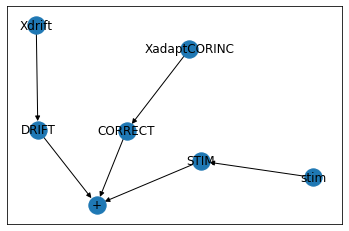

In [170]:
# define the DRIFT network
drift_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, data.Xdrift.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0, # Q: what norm type is this and why should we use it?
    NLtype='lin')
drift_pars['reg_vals'] = {'d2t': 0.2, 'bcs': {'d2t': 0}}
drift_net = FFnetwork.ffnet_dict(xstim_n='Xdrift', layer_list=[drift_pars])


# define the DIST network
correct_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, XadaptCORINC.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='lin')
correct_pars['reg_vals'] = {'d2t': 0.1, 'bcs': {'d2t': 0}}
correct_net = FFnetwork.ffnet_dict(xstim_n='XadaptCORINC', layer_list=[correct_pars])


# define the STIM network
stim_layer = NDNLayer.layer_dict(
    input_dims=data.stim_dims,
    num_filters=data.NC,
    bias=False,
    initialize_center=True,
    NLtype='lin')
stim_layer['reg_vals'] = {'d2xt': 0.2, 'bcs':{'d2xt': 1}}
stim_net = FFnetwork.ffnet_dict(xstim_n='stim', layer_list=[stim_layer])


# define the COMBINE network
comb_layer = ChannelLayer.layer_dict(
    num_filters=data.NC,
    NLtype='softplus',
    bias=True)
comb_layer['weights_initializer'] = 'ones'
comb_net = FFnetwork.ffnet_dict(xstim_n=None, ffnet_n=[0, 1, 2], layer_list=[comb_layer], ffnet_type='add')


# define the COMPLETE model
correct_mod = NDN.NDN(ffnet_list=[drift_net, correct_net, stim_net, comb_net], loss_type='poisson')


# copy the fit drift weights into this network and freeze them
correct_mod.networks[0].layers[0].weight.data = deepcopy(driftw)
correct_mod.set_parameters(val=False, name='weight', ffnet_target=0)


# Draw the network
ml.draw_network(correct_mod, ['DRIFT', 'CORRECT', 'STIM','+'] )


# Train the complete correct_mod
# it automatically uses the train_inds specified in the Dataset object when calling fit()
correct_mod.fit(data, force_dict_training=True, **lbfgs_pars, verbose=1)
# Evaluate the complete correct_mod
LLsALL = correct_mod.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LL-Adapt:", np.mean(LLsDrift - LLsALL))

## analyze results

<Figure size 432x288 with 0 Axes>

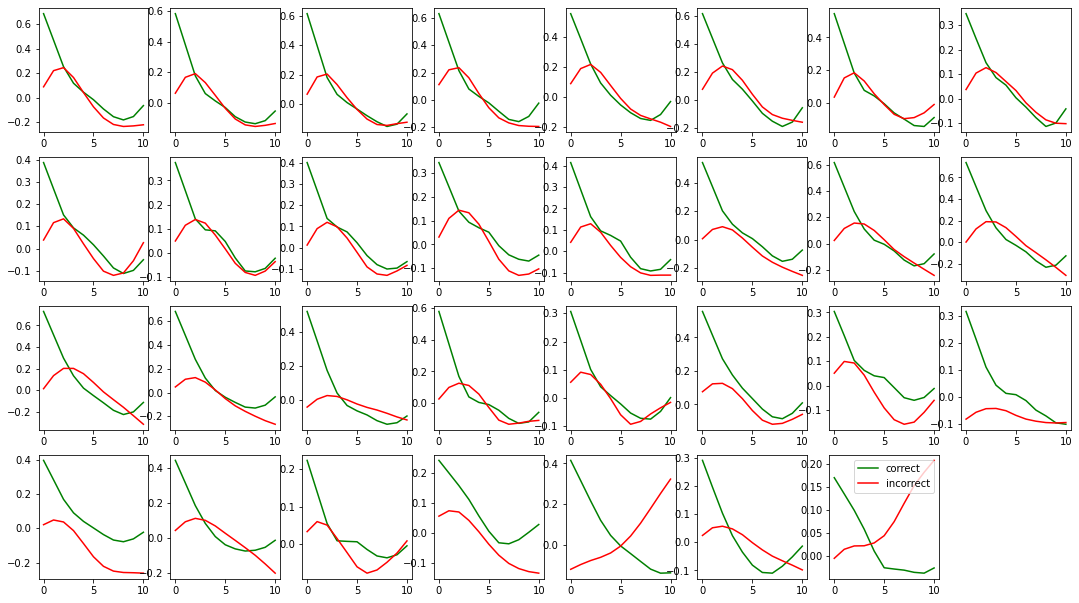

In [171]:
fig = m.fig()
fig.set_size_inches(18.5, 10.5)
for c in range(data.NC):
    plt.subplot(4,8, c+1)
    plt.plot(correct_mod.networks[1].layers[0].weight.data[range(0,11), c], 'green', label='correct')
    plt.plot(correct_mod.networks[1].layers[0].weight.data[range(11,22), c], 'red', label='incorrect')
plt.legend()
plt.show()

In [27]:
'''
The responses are very similar from about the middle of the trial on.
When the choice is incorrect, we see that the neurons have a delay before they begin to follow the behavior of a correct response.

INTERPRETATION:
MAYBE all incorrect responses are FAR responses? 
This behavior matches the other results for FAR stimuli.
TODO: check this, maybe put the data in Pandas to make it easier to slice and dice and create new features for training.
'''

# AUTOENCODER

## create the smoothed_robs features

In [28]:
# add the smoothed robs into the model as a covariate
sm_robs100 = lv.smooth(data.robs, n=100)
data.add_covariate('smoothed_robs', sm_robs100)
sm_robs100.shape, data.stim_dims

((118679, 31), [1, 11, 1, 12])

## train the model

Model: M031_N_N_N_NN_A

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 45.95081901550293 sec elapsed
Mean LL-Adapt: 0.12493918


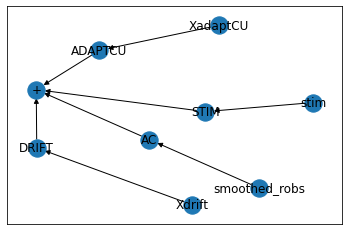

In [159]:
# define the DRIFT network
drift_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, data.Xdrift.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0, # Q: what norm type is this and why should we use it?
    NLtype='lin')
drift_pars['reg_vals'] = {'d2t': 0.2, 'bcs': {'d2t': 0}}
drift_net = FFnetwork.ffnet_dict(xstim_n='Xdrift', layer_list=[drift_pars])


# define the ADAPT network
adapt_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, XadaptCU.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='lin')
adapt_pars['reg_vals'] = {'d2t': 0.1, 'bcs': {'d2t': 0}}
adapt_net = FFnetwork.ffnet_dict(xstim_n='XadaptCU', layer_list=[adapt_pars])


# define the STIM network
stim_layer = NDNLayer.layer_dict(
    input_dims=data.stim_dims,
    num_filters=data.NC,
    bias=False,
    initialize_center=True,
    NLtype='lin')
stim_layer['reg_vals'] = {'d2xt': 0.2, 'bcs':{'d2xt': 1}}
stim_net = FFnetwork.ffnet_dict(xstim_n='stim', layer_list=[stim_layer])


# define the autoencoder network
# input --> LVs (X --> Z)
encoder_layer = NDNLayer.layer_dict(
    # what are these input_dims?
    input_dims=[data.NC, 1, 1, 1], num_filters=7,  # num_LVs --> |Z|
    norm_type=1,  # normalization needed to keep the scale
    # this adjusts the activation threshold by making the output spikes more or less
    bias=False,  # don't put a bias on the input
    NLtype='lin')  # 'lin' -> linear, no nonlinearity applied here
# LVs --> output (Z --> X')
decoder_layer = NDNLayer.layer_dict(
    num_filters=data.NC,
    bias=True, # Q: should we have a bias here? Write out the function.
    NLtype='lin')
# apply L2 regularization on the output
# Q: I don't understand why, though?
decoder_layer['reg_vals'] = {'l2': 0.01}
ac_net = FFnetwork.ffnet_dict(
    xstim_n='smoothed_robs',
    layer_list=[encoder_layer, decoder_layer])


# define the COMBINE network
comb_layer = ChannelLayer.layer_dict(
    num_filters=data.NC,
    NLtype='softplus',
    bias=True)
comb_layer['weights_initializer'] = 'ones'
comb_net = FFnetwork.ffnet_dict(xstim_n=None, ffnet_n=[0, 1, 2, 3], layer_list=[comb_layer], ffnet_type='add')


# define the COMPLETE model
ac_mod = NDN.NDN(ffnet_list=[drift_net, adapt_net, stim_net, ac_net, comb_net], loss_type='poisson')

# copy the fit drift weights into this network and freeze them
ac_mod.networks[0].layers[0].weight.data = deepcopy(driftw)
ac_mod.set_parameters(val=False, name='weight', ffnet_target=0)


# Draw the network
ml.draw_network(ac_mod, ['DRIFT', 'ADAPTCU', 'STIM', 'AC', '+'] )


# Train the complete model
# it automatically uses the train_inds specified in the Dataset object when calling fit()
ac_mod.fit(data, force_dict_training=True, **lbfgs_pars, verbose=1)
# Q: are the val_inds setup correctly for validation?
#    yes, the Dataset does this automatically
# Q: are there left out test values to compare with?
#    yes, the Dataset has these, data.test_inds
# Q: should we train the DRIFT and ADAPT models first, and then add them in and not train all at once?
#    just train the DRIFT first and freeze the values, the DRIFT model is the NULL model,
#    b/c we need to account for drift and not just average firing rate
LLsALL = ac_mod.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LL-Adapt:", np.mean(LLsDrift - LLsALL))

# Q: Adding in the autoencoder with the robs massively improves the LL,
#    is this because we now are predicting the robs with the robs?
#    The LLs goes up with additional latents,
#    which is expected as we have more parameters to capture the 31 cells activity.

## look at the weights

<Figure size 432x288 with 0 Axes>

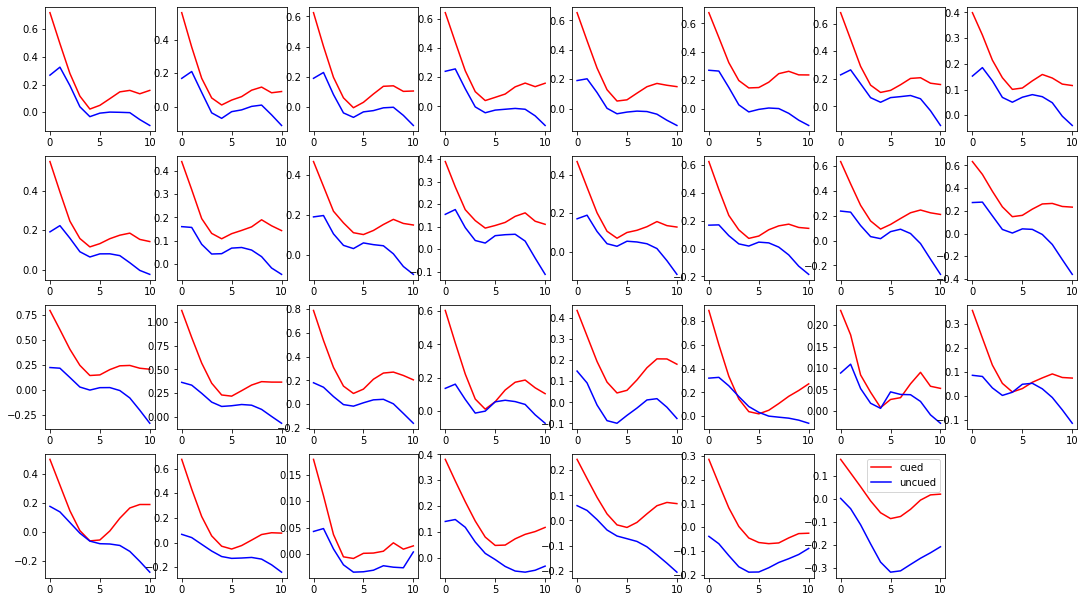

In [161]:
# compare XadaptU with XadaptC weights after fitting the model
fig = m.fig()
fig.set_size_inches(18.5, 10.5)
for c in range(data.NC):
    plt.subplot(4,8, c+1)
    plt.plot(ac_mod.networks[1].layers[0].weight.data[range(0,11), c], 'r', label='cued')
    plt.plot(ac_mod.networks[1].layers[0].weight.data[range(11,22), c], 'b', label='uncued')
plt.legend()
plt.show()


## analyze the latents

In [30]:
redo()
R = ut.construct_R_matrix(data)
Z = ut.construct_Z_matrix(R, ac_mod, ac_network=3, num_latents=3)
Z.shape # trials X time X latents

(848, 121, 3)

/tmp/ipykernel_31147/3420112011.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<Figure size 432x288 with 0 Axes>

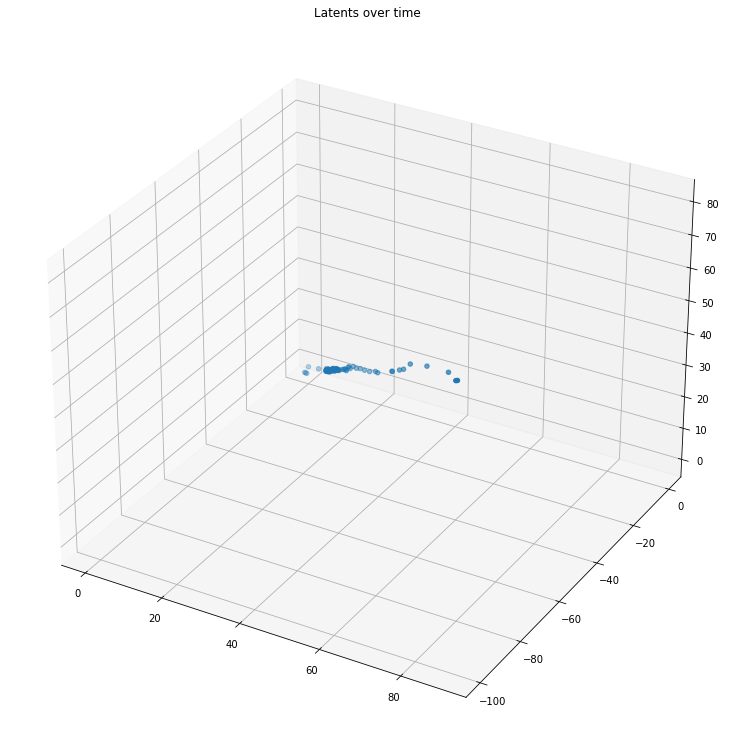

In [31]:
fig = m.fig()
ax = Axes3D(fig)
# average over trials to get the latents over time
ax.scatter(np.mean(Z, axis=0).T[0],
           np.mean(Z, axis=0).T[1],
           np.mean(Z, axis=0).T[2])
plt.title("Latents over time")
plt.show()

<Figure size 432x288 with 0 Axes>

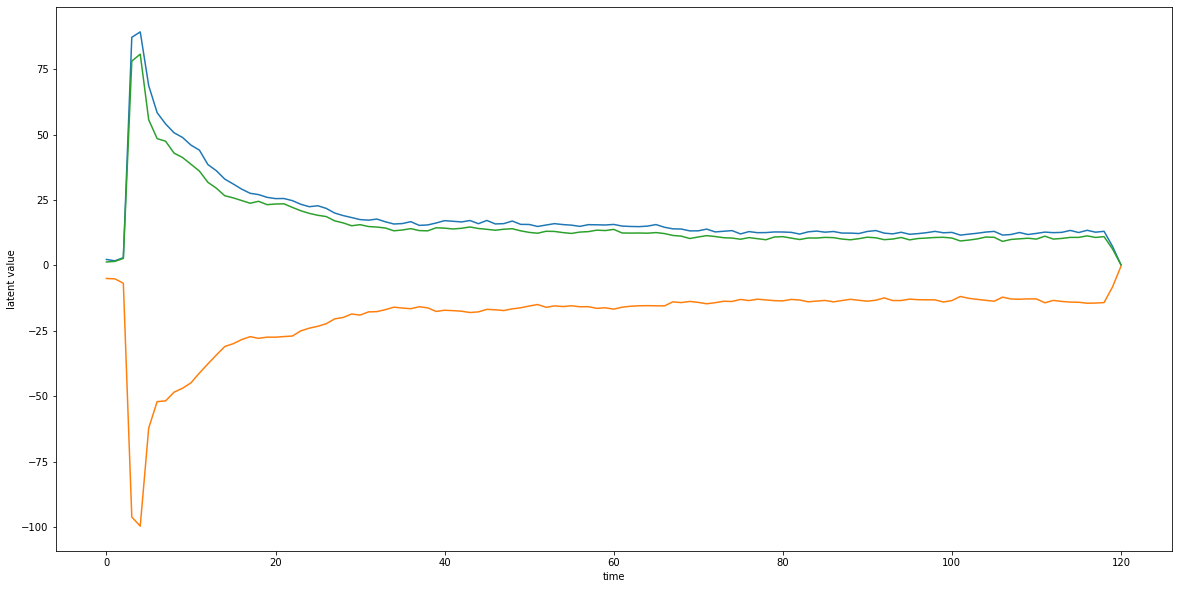

In [32]:
# plot latents averaged over trials
m.fig()
plt.plot(np.mean(Z, axis=0).T[0])
plt.plot(np.mean(Z, axis=0).T[1])
plt.plot(np.mean(Z, axis=0).T[2])
plt.xlabel("time")
plt.ylabel("latent value")
plt.show()

## cued vs. uncued

In [33]:
## 3a find centroids of latents for cued and uncued trials
trcued = np.where(data.TRcued < 0)[0]
truncued = np.where(data.TRcued > 0)[0]
trcued_mean = np.mean(np.mean(Z[trcued], axis=1), axis=0)
truncued_mean = np.mean(np.mean(Z[truncued], axis=1), axis=0)

## 3b calculate vector between the centroids
centroid_vector = trcued_mean - truncued_mean
centroid_vector /= np.sqrt(centroid_vector @ centroid_vector.T)
centroid_vector = np.array([centroid_vector])
print(centroid_vector)

## 3c fit logistic regression model between cued and uncued
# separate cued-uncued points via logistic regression instead of centroids
from sklearn.linear_model import LogisticRegression

cued_trial_model = LogisticRegression(random_state=0).fit(np.mean(Z, axis=1), data.TRcued)

## 3d calculate hyperplane vector
hyperplane_vector = (cued_trial_model.coef_ / np.sqrt(cued_trial_model.coef_ @ cued_trial_model.coef_.T))
print(hyperplane_vector)

[[-0.6095105   0.57595641 -0.54476707]]
[[-0.48792781 -0.70197208  0.51880791]]


<Figure size 432x288 with 0 Axes>

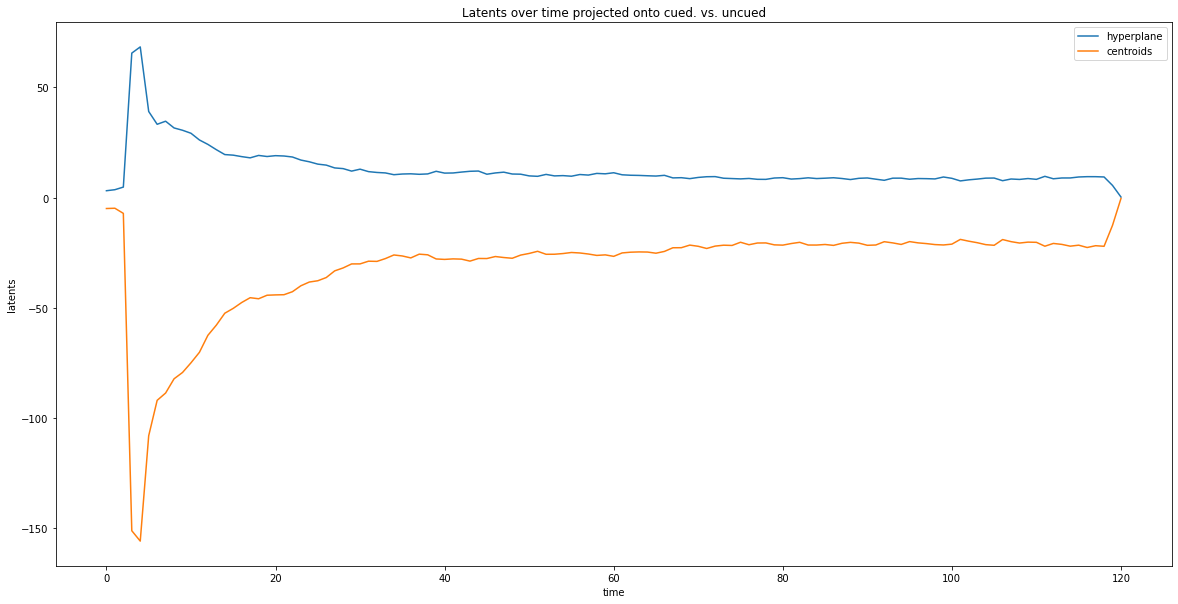

In [34]:
# project the latents over time onto the cued vs. uncued vectors
m.fig()
plt.plot((hyperplane_vector @ np.mean(Z, axis=0).T).T, label="hyperplane")
plt.plot((centroid_vector @ np.mean(Z, axis=0).T).T, label="centroids")
plt.title("Latents over time projected onto cued. vs. uncued")
plt.xlabel("time")
plt.ylabel("latents")
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

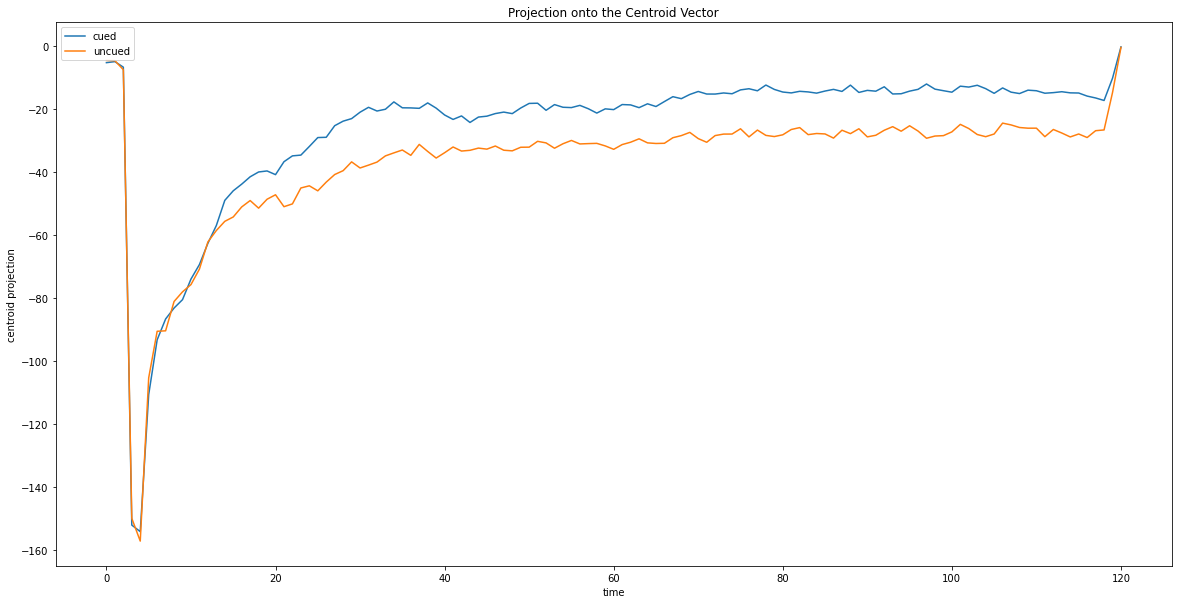

In [35]:
m.fig()
plt.plot((centroid_vector @ np.mean(Z[trcued], axis=0).T).T, label="cued")
plt.plot((centroid_vector @ np.mean(Z[truncued], axis=0).T).T, label="uncued")
plt.legend()
plt.xlabel("time")
plt.ylabel("centroid projection")
plt.title("Projection onto the Centroid Vector")
plt.show()

<Figure size 432x288 with 0 Axes>

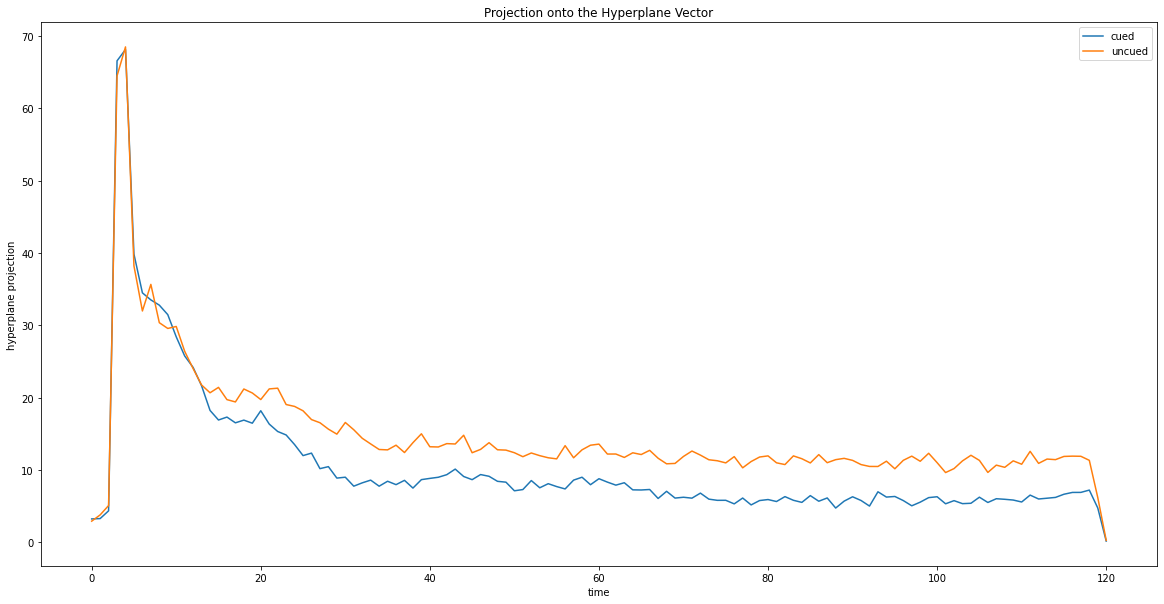

In [36]:
m.fig()
plt.plot((hyperplane_vector @ np.mean(Z[trcued], axis=0).T).T, label="cued")
plt.plot((hyperplane_vector @ np.mean(Z[truncued], axis=0).T).T, label="uncued")
plt.legend()
plt.xlabel("time")
plt.ylabel("hyperplane projection")
plt.title("Projection onto the Hyperplane Vector")
plt.show()

## TODO: look at correctness over time projected onto attention vector

# ----------------------------

In [37]:
assert False # raise exception to stop execution here

AssertionError: 

# ----- TESTING -----
Generate the spike train and compare with ground truth (with left-out test set)
--------- NOTE THIS IS NOTHING RIGHT NOW ------------------

In [ ]:
# get the weights for the DRIFT network
driftw = model.networks[0].layers[0].weight.data
data.Xdrift.shape, driftw.shape

In [ ]:
model.set_parameters(val=False, name='weight', ffnet_target=3)
model.set_parameters(val=False, name='weight', ffnet_target=0)
model.list_parameters()

In [ ]:
predRs = data.Xdrift @ driftw
m.fig()
plt.plot(predRs[:,0])
plt.title("Drift for Neuron 1")
plt.show()

In [ ]:
m.fig()
plt.plot(driftw.numpy()[:,0])
plt.show()

In [ ]:
adaptw = model.networks[1].layers[0].weight.data
print(adaptw.shape)
m.fig()
plt.plot(adaptw.numpy())
plt.show()

In [ ]:
stimw = model.networks[2].layers[0].weight.data
data.stim.shape, stimw.shape, data.robs.shape

In [ ]:
predRs = data.stim @ stimw
m.fig()
plt.plot(predRs[:,0][:100])
plt.plot(data.robs[:,0][:100])
plt.title("Firing Rate for Neuron 1")
plt.show()

In [ ]:
# TODO: combine cued/uncued with multiplication in its own network -- Does Attentional Gain affect firing in an additive or multiplicate way?
#       and compare accuracy with addition